# Band structure, Fermi surface and DOS for 1NN model

Columns in DataFrame: 7


TypeError: can only concatenate str (not "complex") to str

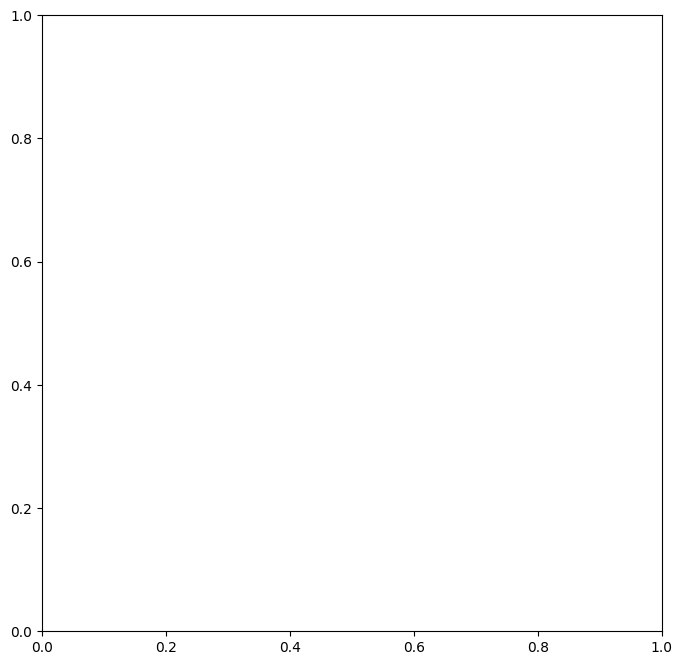

In [3]:
import numpy as np
import pandas as pd
from scipy.fft import fftn, ifftn, fftshift

import matplotlib.pyplot as plt

def get_dat(file_name):

    df = pd.read_fwf(file_name +'.dat', delimiter=' ', comment='#', header=None, skiprows=4)  # Specify your delimiter here
    Rx = df[0].to_numpy()
    Ry = df[1].to_numpy()
    print("Columns in DataFrame:", df.shape[1])
    # Rz = df[2].to_numpy() not needed

    tr = df[5].to_numpy()
    ti = df[6].to_numpy()
    

    return(Rx, Ry, tr, ti)

rx1,ry1,tr1,ti1 = get_dat("1NN_hr_2")



def pair(ks,rx, ry, tr, ti):
    """
    Function that returns the energy values for a given  path ks, t following a NN hopping 2D square lattice
    Inputs:
    -ks: array of momenta  showing the total length of our path T-M-X-T
    -rx, ry: parameters from input data (real bravais vectors)
    -tr: real part of the hopping amplitude
    -ti: imaginary part of the hopping amplitude
    Outputs:
    -dispersion: array of energy values corresponding to ks values 
    """
    if 0 <= ks <= (np.pi): #along T-M contour
        kx=ks
        ky=0
    elif (np.pi) < ks <= (2*(np.pi)):
        kx=(np.pi)
        ky=ks-(np.pi)
    elif 2*(np.pi) < ks <=(2 + np.sqrt(2))*(np.pi):
        kx= -ks/np.sqrt(2) +  ((1+np.sqrt(2))*(np.pi))
        ky= -ks/np.sqrt(2) +  ((1+np.sqrt(2))*(np.pi))
    dispersion= sum((tr[i] + 1j*ti[i])* np.exp(1j*(kx*rx[i] + ky*ry[i]))for i in range(len(tr)))   #note that this currently has no distinction between whether the hopping is 1-2, 1-3 or so forth
    return (dispersion)

#plot band structure

fig, ax1 = plt.subplots(figsize=(8, 8))
ks=np.linspace(0, (2+np.sqrt(2))*np.pi, 200)  #total length of our path T-M-X-T in k space

energy=np.zeros(len(ks))
for i in range(len(ks)):
    energy[i]= pair(ks[i],rx1,ry1,tr1,ti1)

ax1.plot(ks,energy)
x = [0, (np.pi), 2*(np.pi), (2+np.sqrt(2))*(np.pi)] 
    
labels = ['$\Gamma$', 'M', 'X', '$\Gamma$'] 
for y in x:
    plt.axvline(x=y,color="black", linestyle='--', linewidth=2,)


plt.xticks(x, labels, rotation ='horizontal') 

ax1.set_title(f" Figure 1.1 $\Gamma$-X-M-$\Gamma$ Band structure plot for the 1NN model in 2D, t' = 0.5", size=12)
ax1.set_ylabel("Energy (eV)")









In [4]:
#fermi surface plot

kx=np.arange(-(np.pi), (np.pi), 0.05)
ky=np.arange(-(np.pi), (np.pi), 0.05)
X, Y = np.meshgrid(kx, ky)
def dispersion_FS(tr,ti,X,Y,rx,ry): 
    dispersion  = sum((tr[i] + ti[i])* np.exp(1j*(X*rx[i] + Y*ry[i])) for i in range(len(tr)))
    return dispersion


dispersion1 = dispersion_FS(tr1,ti1,X,Y,rx1, ry1)

fig, ax = plt.subplots(figsize=(16, 6))
ax.set_aspect(1)
ax.grid()
#C = ax.contourf(X, Y, dispersion1, levels=25, cmap="plasma");

C_zero = ax.contour(X, Y, dispersion1, levels=[0], colors='teal', linewidths=1.5)
ax.clabel(C_zero, fmt=f"$\epsilon_F=0$", inline=True, fontsize=10, colors='teal')
ax.set_title("Figure 1.2 Fermi Surface contour plot for the 1NN model in 2D ", size=10)
ax.set_xlabel(f'$k_x$')
ax.set_ylabel(f'$k_y$');

plt.show()



TypeError: can only concatenate str (not "numpy.float64") to str

NameError: name 'dispersion1' is not defined

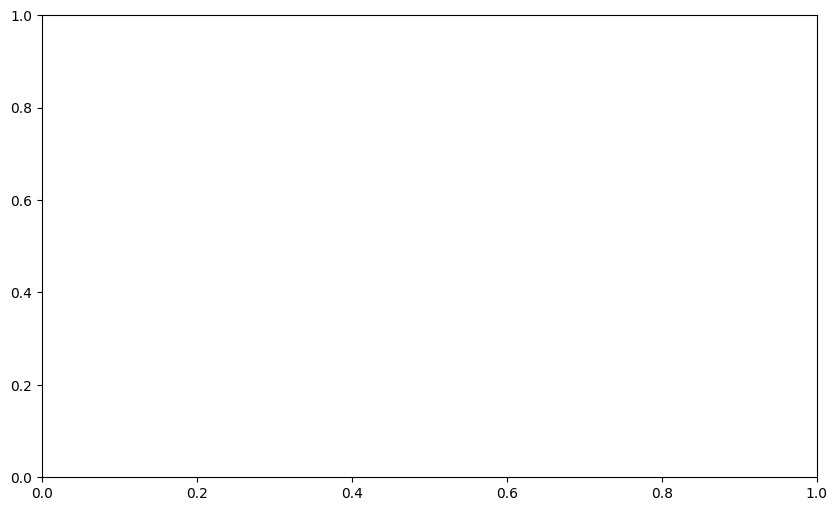

In [5]:
#plot the DOS

Es = np.arange(-4,4,0.01)

eta = 0.05

def calc_DOS(dispersion, Es):

    dos = np.zeros_like(Es)
    for k, epsilon in enumerate(Es):

        G_k  = 1 / (epsilon - dispersion + 1j * eta)  #green's function

        Gks = np.sum(G_k)
        

        dos[k]= -1/np.pi * np.imag(Gks)

    return dosmeetings


fig, ax = plt.subplots(figsize=(10, 6))

dos1 = calc_DOS(dispersion1, Es)
ax.plot(Es, dos1, color = 'teal', label = f"Broadening = {eta}eV")
ax.set_title("Figure 1.3 DOS of 2D 1NN mnodel")
ax.legend()
ax.set_xlabel("Energy(eV)")
ax.set_ylabel("DOS")




 # 2 Band structure, FS and DOS for 2NN

In [7]:
#redefine get_dat_mutdim   for multiple bands
#first read the number of orbitals in order to set up a matrix of that dimension
import sympy as sp
from sympy import symbols, Matrix, simplify

#define k symbols
kx= symbols('kx', real= True)
ky= symbols('ky', real= True)

def get_dat_mutdim(file_name, n):
    """
    n: number of lines to skip
    """
    #first find the dimension of the matrix
    with open(file_name + '.dat', 'r') as file:
        for line_number, line in enumerate(file, 1):  # Start counting from 1
            if line_number == 2:
                second_line = line.strip()  # Use .strip() as needed
                dim= int(second_line)
                break
   
    H = sp.Matrix([[sp.S.Zero for _ in range(dim)] for _ in range(dim)])


    #store the data

    df = pd.read_csv(
        file_name + '.dat',
        sep='\s+',          
        comment='#',       
        header=None,        
        skiprows=n,         
        engine='python'     # Set your Fermi energy here
    )



    for _, row in df.iterrows():
        x = int(row[3]) -1
        y = int(row[4]) -1
        

        rx = row[0]
        ry = row[1]
        tr = row[5]
        ti = row[6]

        phase = sp.exp(sp.I*(kx*rx + ky*ry))  # SymPy exponential
        val = (tr + sp.I*ti) * phase


        H[x,y] += val

    return H


H2 = get_dat_mutdim("2NN_hr",n=4)

P, D = H2.diagonalize()  #diagonalise
#simplify
P = P.applyfunc(sp.simplify)
D = D.applyfunc(sp.simplify) # diagonal matrix


        

subs_dict = {kx : 0, ky: 0}
H2_subs = H2.subs(subs_dict)
H2_numeric = np.array(H2_subs, dtype=complex)  # Ensure numeric type
eigenvalues, eigenvectors = np.linalg.eig(H2_numeric)






    #nearest neighbour hopping t=1.0
         1
         5
 1 1 1 1 1
 0.0  0.0 0.0 1 1 0.0 0.0
 1.0  0.0 0.0 1 1 1.0 0.0
-1.0  0.0 0.0 1 1 1.0 0.0
 0.0  1.0 0.0 1 1 1.0 0.0
 0.0 -1.0 0.0 1 1 1.0 0.0

    





/home/oem/Documents/Final year project/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/oem/Documents/Final year project/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


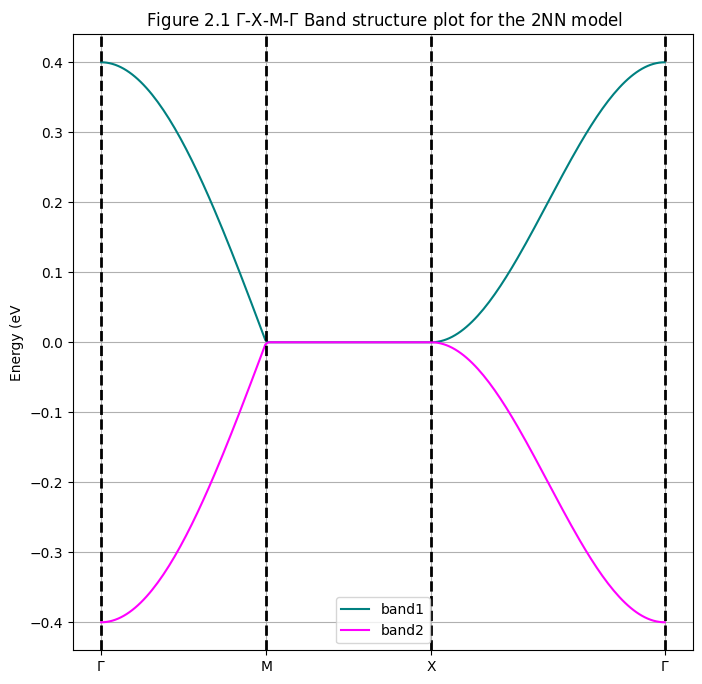

In [8]:
def pair(ks_, H2):
    """
    Function that returns the energy values for a given  path ks, t following a NN hopping 2D square lattice
    Inputs:
    -ks: array of momenta  showing the total length of our path T-M-X-T
    -rx, ry: parameters from input data (real bravais vectors)
    -tr: real part of the hopping amplitude
    -ti: imaginary part of the hopping amplitude
    Outputs:
    -dispersion: array of energy values corresponding to ks values 

    """
    band1 = []
    band2 = []
   
    for ks in ks_:
    
        if 0 <= ks <= (np.pi): #along T-M contour
            kxs=ks
            kys=0
        elif (np.pi) < ks <= (2*(np.pi)):
            kxs=(np.pi)
            kys=ks-(np.pi)
        elif 2*(np.pi) < ks <=(2 + np.sqrt(2))*(np.pi):
            kxs= -ks/np.sqrt(2) +  ((1+np.sqrt(2))*(np.pi))
            kys= -ks/np.sqrt(2) +  ((1+np.sqrt(2))*(np.pi))

   
        subs_dict = {kx : kxs, ky:kys}
        H2_subs = H2.subs(subs_dict)
        H2_numeric = np.array(H2_subs, dtype=complex)  
        eigenvalues, eigenvectors = np.linalg.eig(H2_numeric)
        band1.append(eigenvalues[0])
        band2.append(eigenvalues[1])


    return (band1, band2)

ks=np.linspace(0, (2+np.sqrt(2))*np.pi, 200)
band1, band2= pair(ks, H2)





fig, ax1 = plt.subplots(figsize=(8, 8))

ax1.plot(ks, band1, color='teal', label='band1')
ax1.plot(ks, band2, color='magenta', label= 'band2')


labels = ['$\Gamma$', 'M', 'X', '$\Gamma$'] 
for y in x:
    plt.axvline(x=y,color="black", linestyle='--', linewidth=2,)


plt.xticks(x, labels, rotation ='horizontal') 

ax1.set_title(f" Figure 2.1 $\Gamma$-X-M-$\Gamma$ Band structure plot for the 2NN model ", size=12)
ax1.set_ylabel("Energy (eV")    
ax1.legend()
ax1.grid()       





    

                                               0.5
    ⎛ ⅈ⋅kx      ⎞ ⎛ ⅈ⋅ky      ⎞ ⎛ -ⅈ⋅(kx + ky)⎞   
0.1⋅⎝ℯ     + 1.0⎠⋅⎝ℯ     + 1.0⎠⋅⎝ℯ            ⎠   
                                                0.5
     ⎛ ⅈ⋅kx      ⎞ ⎛ ⅈ⋅ky      ⎞ ⎛ -ⅈ⋅(kx + ky)⎞   
-0.1⋅⎝ℯ     + 1.0⎠⋅⎝ℯ     + 1.0⎠⋅⎝ℯ            ⎠   


Text(0, 0.5, 'ky')

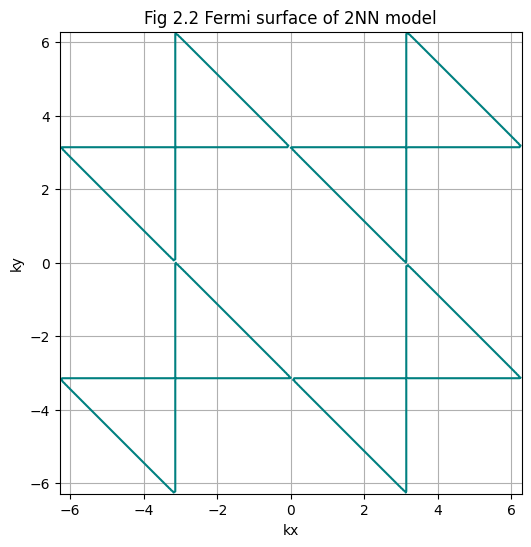

In [9]:
# plot the fermi surface
sp.pprint(D[1,1])
sp.pprint(D[0,0])

kx= symbols('kx', real= True)
ky= symbols('ky', real= True)

from sympy import symbols, lambdify

D11 = lambdify([kx, ky], sp.re(D[0, 0]), 'numpy')
D22 = lambdify([kx, ky], sp.re(D[1, 1]), 'numpy')


kxs=np.linspace(-(2*np.pi), (2*np.pi), 200)
kys=np.linspace(-(2*np.pi), (2*np.pi), 200)
X, Y = np.meshgrid(kxs, kys)

D11_val = D11(X,Y)

D22_val = D22(X,Y)



dispersion_band1 = D11_val 
dispersion_band2 = D22_val



fig, ax = plt.subplots(figsize=(16, 6))
ax.set_aspect(1)
ax.grid()
C_zero1 = ax.contour(X, Y, dispersion_band1, levels=[0], colors='teal', linewidths=1.5)
#ax.clabel(C_zero1, fmt=f"$\epsilon_F=0$, band1", inline=True, fontsize=10, colors='teal')
#C = ax.contour(X,Y, dispersion_band1)
#C2 = ax.contourf(X,Y, dispersion_band2, levels =25)

#C_zero2 = ax.contour(X, Y, dispersion_band2, levels=[0], colors='magenta', linewidths=1.5)
#ax.clabel(C_zero2, fmt=f"$\epsilon_F=0$, band2", inline=True, fontsize=10, colors='magenta')

ax.set_title("Fig 2.2 Fermi surface of 2NN model")
ax.set_xlabel("kx")
ax.set_ylabel("ky")





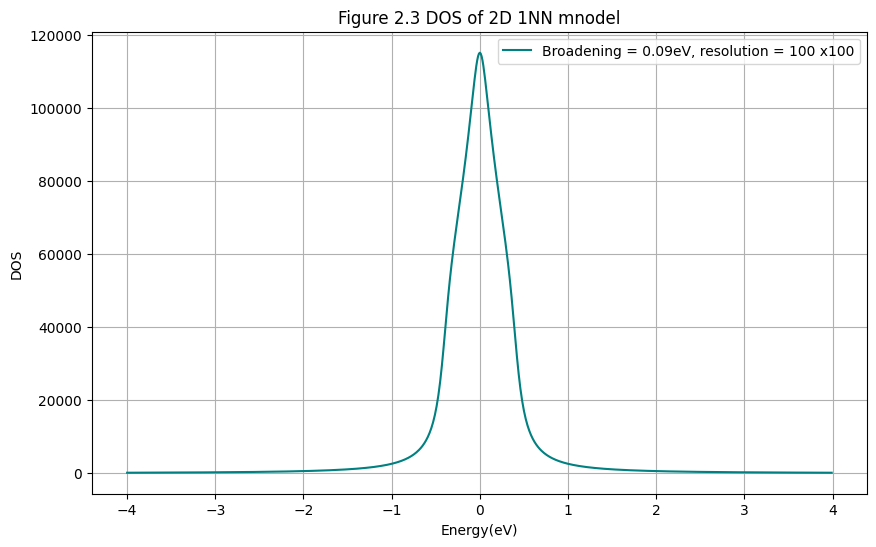

In [10]:
#DOS

Es = np.arange(-4,4,0.01)

eta = 0.09



def calc_DOS(dispersion, Es):

    dos = np.zeros_like(Es)

    
    for k, epsilon in enumerate(Es):

        G_k  = 1 / (epsilon - dispersion + 1j * eta)  #green's function

        Gks = np.sum(G_k)
        

        dos[k]= -1/np.pi * np.imag(Gks)

    return dos


fig, ax = plt.subplots(figsize=(10, 6))




dos2a = calc_DOS(dispersion_band1, Es)
dos2b = calc_DOS(dispersion_band2, Es)

dos_2tot = dos2a +dos2b

ax.plot(Es, dos_2tot, color = 'teal', label = f"Broadening = {eta}eV, resolution = 100 x100")
#ax.plot(Es, dos2a, color = 'teal', label = f"Broadening = {eta}eV, band 1")
#ax.plot(Es, dos2b, color = 'magenta', label = f"Broadening = {eta}eV, band 2 ")
ax.set_title("Figure 2.3 DOS of 2D 1NN mnodel")
ax.legend()
ax.set_xlabel("Energy(eV)")
ax.set_ylabel("DOS")
ax.grid()

# Band structure, FS and DOS for Sr214M model

/home/oem/Documents/Final year project/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/oem/Documents/Final year project/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


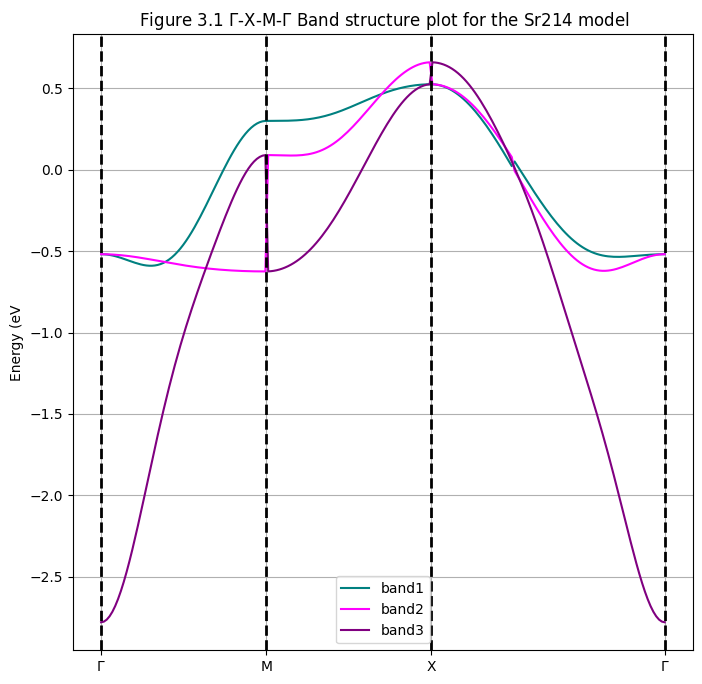

In [11]:
#band structure


H3 = get_dat_mutdim("Sr214M_hr",n=7)


def pair3(ks_, H):
    """
    Function that returns the energy values for a given  path ks, t following a NN hopping 2D square lattice
    Inputs:
    -ks: array of momenta  showing the total length of our path T-M-X-T
    -rx, ry: parameters from input data (real bravais vectors)
    -tr: real part of the hopping amplitude
    -ti: imaginary part of the hopping amplitude
    Outputs:
    -dispersion: array of energy values corresponding to ks values 

    """
    band1 = [] 
    band2 = []
    band3 = []
   
    for ks in ks_:
    
        if 0 <= ks <= (np.pi): #along T-M contour
            kxs=ks
            kys=0
        elif (np.pi) < ks <= (2*(np.pi)):
            kxs=(np.pi)
            kys=ks-(np.pi)
        elif 2*(np.pi) < ks <=(2 + np.sqrt(2))*(np.pi):
            kxs= -ks/np.sqrt(2) +  ((1+np.sqrt(2))*(np.pi))
            kys= -ks/np.sqrt(2) +  ((1+np.sqrt(2))*(np.pi))

        
        subs_dict = {kx : kxs, ky:kys}
        H_subs = H.subs(subs_dict)
        H_numeric = np.array(H_subs, dtype=complex)  
        eigenvalues, eigenvectors = np.linalg.eig(H_numeric)
        band1.append(eigenvalues[0])
        band2.append(eigenvalues[1])
        band3.append(eigenvalues[2])


    return (band1, band2, band3)

ks=np.linspace(0, (2+np.sqrt(2))*np.pi, 200)

band1, band2, band3 = pair3(ks, H3)





fig, ax1 = plt.subplots(figsize=(8, 8))

ax1.plot(ks, band1, color='teal', label='band1')
ax1.plot(ks, band2, color='magenta', label= 'band2')
ax1.plot(ks, band3, color='purple', label= 'band3')


labels = ['$\Gamma$', 'M', 'X', '$\Gamma$'] 
for y in x:
    plt.axvline(x=y,color="black", linestyle='--', linewidth=2,)


plt.xticks(x, labels, rotation ='horizontal') 

ax1.set_title(f" Figure 3.1 $\Gamma$-X-M-$\Gamma$ Band structure plot for the Sr214 model ", size=12)
ax1.set_ylabel("Energy (eV")    
ax1.legend()
ax1.grid()       



/tmp/ipykernel_13002/3283559350.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[i, j] = eigvals[0]
/tmp/ipykernel_13002/3283559350.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues2[i,j] = eigvals[1]
/tmp/ipykernel_13002/3283559350.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues3[i,j] = eigvals[2]


Text(0, 0.5, 'ky')

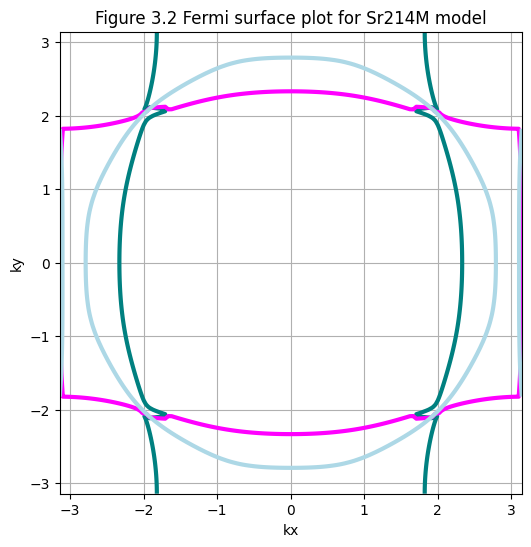

In [16]:
#fermi surface

kx= symbols('kx', real= True)
ky= symbols('ky', real= True)

H3_lambdified = np.array([[sp.lambdify((kx, ky), H3[i, j], 'numpy') for j in range(3)] for i in range(3)])

kxs=np.linspace(-(np.pi), (np.pi), 150)
kys=np.linspace(-(np.pi), (np.pi), 150)
X, Y = np.meshgrid(kxs, kys)

eigenvalues = np.zeros((150, 150))
eigenvalues2 = np.zeros((150,150))
eigenvalues3 = np.zeros((150,150))



for i in range(len(kxs)):
    for j in range(len(kys)):
        matrix_values = np.array([[H3_lambdified[k, l](X[i, j], Y[i, j]) for l in range(3)] for k in range(3)])
        
        # Diagonalize the numerical matrix
        eigvals, eigvecs = np.linalg.eig(matrix_values)
        
        # Store eigenvalues for visualization
        eigenvalues[i, j] = eigvals[0]
        eigenvalues2[i,j] = eigvals[1]
        eigenvalues3[i,j] = eigvals[2]



fig, ax = plt.subplots(figsize=(16, 6))
ax.set_aspect(1)
ax.grid()
C_zero1 = ax.contour(X, Y, eigenvalues, levels=[0], colors='teal', linewidths=3)
C_zero2 = ax.contour(X, Y, eigenvalues2, levels=[0], colors='magenta', linewidths=3)
C_zero3 = ax.contour(X, Y, eigenvalues3, levels=[0], colors='lightblue', linewidths=3)
ax.set_title("Figure 3.2 Fermi surface plot for Sr214M model")
ax.set_xlabel("kx")
ax.set_ylabel("ky")


(-1.0, 1.0)

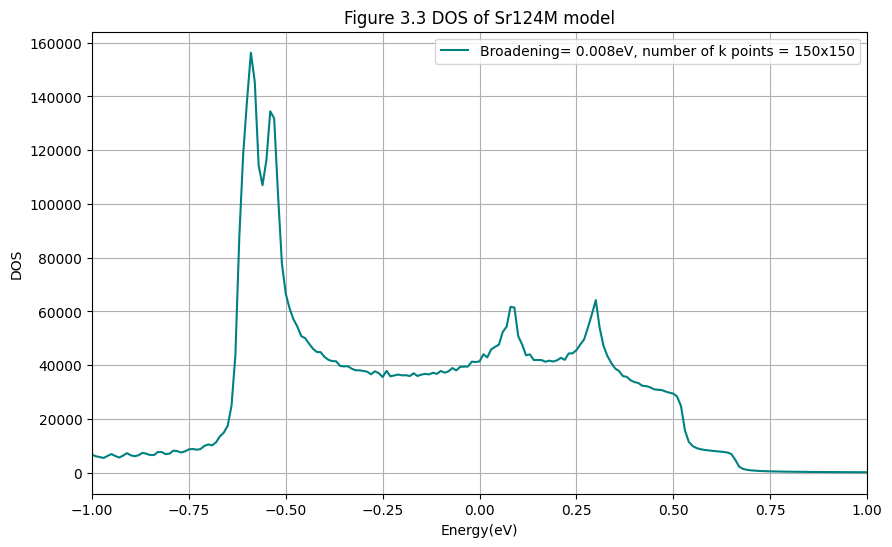

In [20]:
#DOS
eta= 0.008

fig, ax = plt.subplots(figsize=(10, 6))

dos3a = calc_DOS(eigenvalues, Es)
dos3b = calc_DOS(eigenvalues2, Es)
dos3c = calc_DOS(eigenvalues3, Es)

dos_tot = dos3a + dos3b + dos3c
ax.plot(Es, dos_tot, color = 'teal', label = f"Broadening= {eta}eV, number of k points = 150x150")
#x.plot(Es, dos3a, color = 'teal', label = f"Broadening = {eta}eV, band 1")
#x.plot(Es, dos3b, color = 'magenta', label = f"Broadening = {eta}eV, band 2 ")
#x.plot(Es, dos3c, color = 'lightblue', label = f"Broadening = {eta}eV, band 3 ")
ax.set_title("Figure 3.3 DOS of Sr124M model")
ax.legend()
ax.set_xlabel("Energy(eV)")
ax.set_ylabel("DOS")
ax.grid()
ax.set_xlim(-1, 1)

In [9]:
#calculate the number of electrons 

import numpy as np
from scipy.optimize import bisect

# Define the tight-binding dispersion relation
def dispersion(kx, ky, t, t_prime):
    return -2 * t * (np.cos(kx) + np.cos(ky)) - 4 * t_prime * np.cos(kx) * np.cos(ky)

# Compute the density of states integral at given mu
def filling(mu, t, t_prime, num_kpoints=100):
    kx_vals = np.linspace(-np.pi, np.pi, num_kpoints)
    ky_vals = np.linspace(-np.pi, np.pi, num_kpoints)
    kx_grid, ky_grid = np.meshgrid(kx_vals, ky_vals)
    
    energies = dispersion(kx_grid, ky_grid, t, t_prime)
    occupied = energies <= mu  # Step function at T=0
    return np.sum(occupied) / num_kpoints**2  # Normalize by number of k-points

# Find the chemical potential for a given filling
def find_mu(target_n, t, t_prime, num_kpoints=100):
    # Energy bounds (extremes of the band)
    E_min = -2*t - 4*t_prime
    E_max = 2*t + 4*t_prime
    
    # Root-finding for mu that gives the correct filling
    mu_solution = bisect(lambda mu: filling(mu, t, t_prime, num_kpoints) - target_n, E_min, E_max)
    return mu_solution

if __name__ == "__main__":
    # Model parameters
    t = 1.0  # Nearest-neighbor hopping
    t_prime = 0.5# Next-nearest-neighbor hopping
    target_n = 0.5  # Half-filling
    
    mu = find_mu(target_n, t, t_prime)
    print(f"Chemical potential (mu) at filling {target_n} with t'={t_prime}: {mu:.6f}")



Chemical potential (mu) at filling 0.5 with t'=0.5: 1.031250


In [17]:
import numpy as np
from scipy.integrate import cumulative_trapezoid



def dispersion(kx, ky, t, t_prime):
    return -2 * t * (np.cos(kx) + np.cos(ky)) - 4 * t_prime * np.cos(kx) * np.cos(ky)

def compute_dos(t, t_prime, num_kpoints=200):
    kx_vals = np.linspace(-np.pi, np.pi, num_kpoints)
    ky_vals = np.linspace(-np.pi, np.pi, num_kpoints)
    kx_grid, ky_grid = np.meshgrid(kx_vals, ky_vals)
    energies = dispersion(kx_grid, ky_grid, t, t_prime).flatten()
    
    hist, bin_edges = np.histogram(energies, bins=100, density=True)
    dos = hist / np.sum(hist)  
    energy_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return energy_centers, dos


def find_mu_exact(t, t_prime, num_kpoints=200):
    energy_centers, dos = compute_dos(t, t_prime, num_kpoints)
    
    cumulative_dos = cumulative_trapezoid(dos, energy_centers, initial=0)  
    cumulative_dos /= cumulative_dos[-1]  
   
    mu_exact = np.interp(0.5, cumulative_dos, energy_centers)
    return mu_exact

if __name__ == "__main__":
   
    t = 1.0  # NN
    t_prime = 0.75  # NN
    
    mu = find_mu_exact(t, t_prime)
    print(f"Exact chemical potential (mu) at half-filling with t'={t_prime}: {mu:.6f}")


Exact chemical potential (mu) at half-filling with t'=0.75: 1.101209
